In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
%matplotlib inline 

In [2]:
mnist = input_data.read_data_sets("data/", one_hot=True)
trainimgs   = mnist.train.images
trainlabels = mnist.train.labels
testimgs    = mnist.test.images
testlabels  = mnist.test.labels
ntrain      = trainimgs.shape[0]
ntest       = testimgs.shape[0]
dim         = trainimgs.shape[1]
nout        = trainlabels.shape[1]
print ("Packages loaded")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Packages loaded


In [24]:
n1 = 16
n2 = 32
n3 = 64
ksize = 5
weights = {
    'encoder_1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1],  stddev=0.1)),
    'encoder_2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1)),
    'encoder_3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1)),
    'decoder_3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1)),
    'decoder_2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1)),
    'decoder_1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1],  stddev=0.1))
}
biases = {
    'encoder_1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'encoder_2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'encoder_3': tf.Variable(tf.random_normal([n3], stddev=0.1)),
    'decoder_3': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'decoder_2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'decoder_1': tf.Variable(tf.random_normal([1],  stddev=0.1))
}
def encoder_decoder(_X, _W, _b, _keepprob):
    input_r = tf.reshape(_X, shape=[-1, 28, 28, 1])
    # Encoder
    encoder_1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(input_r, _W['encoder_1']
        , strides=[1, 2, 2, 1], padding='SAME'), _b['encoder_1']))
    encoder_1 = tf.nn.dropout(encoder_1, _keepprob)
    encoder_2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(encoder_1, _W['encoder_2']
        , strides=[1, 2, 2, 1], padding='SAME'), _b['encoder_2'])) 
    encoder_2 = tf.nn.dropout(encoder_2, _keepprob)
    encoder_3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(encoder_2, _W['encoder_3']
        , strides=[1, 2, 2, 1], padding='SAME'), _b['encoder_3'])) 
    encoder_3 = tf.nn.dropout(encoder_3, _keepprob)
    # Decoder
    decoder_3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(encoder_3, _W['decoder_3']
        , tf.pack([tf.shape(_X)[0], 7, 7, n2]), strides=[1, 2, 2, 1]
        , padding='SAME'), _b['decoder_3'])) 
    decoder_3 = tf.nn.dropout(decoder_3, _keepprob)
    decoder_2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(decoder_3, _W['decoder_2']
        , tf.pack([tf.shape(_X)[0], 14, 14, n1]), strides=[1, 2, 2, 1]
        , padding='SAME') , _b['decoder_2'])) 
    decoder_2 = tf.nn.dropout(decoder_2, _keepprob)
    decoder_1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(decoder_2, _W['decoder_1']
        , tf.pack([tf.shape(_X)[0], 28, 28, 1]), strides=[1, 2, 2, 1]
        , padding='SAME'), _b['decoder_1'])) 
    decoder_1 = tf.nn.dropout(decoder_1, _keepprob)
    out = decoder_1
    return {'input_r': input_r, 'encoder_1': encoder_1, 'encoder_2': encoder_2, 'encoder_3': encoder_3
        , 'decoder_3': decoder_3, 'decoder_2': decoder_2, 'decoder_1': decoder_1
        , 'layers': (input_r, encoder_1, encoder_2, encoder_3, decoder_3, decoder_2, decoder_1)
        , 'out': out}
print ("Network ready")

Network ready


In [26]:
x = tf.placeholder(tf.float32, [None, dim])
y = tf.placeholder(tf.float32, [None, dim])
keepprob = tf.placeholder(tf.float32)
pred = encoder_decoder(x, weights, biases, keepprob)['out']
cost = tf.reduce_sum(tf.square(encoder_decoder(x, weights, biases, keepprob)['out'] 
            - tf.reshape(y, shape=[-1, 28, 28, 1])))
learning_rate = 0.001
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.initialize_all_variables()
print ("Functions ready")

Functions ready


Strart training..
[00/05] cost: 7352.5054


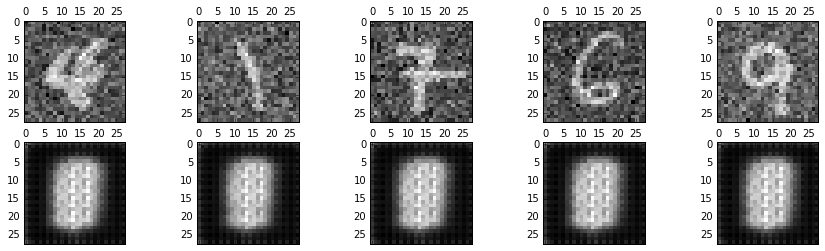

In [ ]:
sess = tf.Session()
sess.run(init)
# mean_img = np.mean(mnist.train.images, axis=0)
mean_img = np.zeros((784))
# Fit all training data
batch_size = 128
n_epochs   = 5
print("Strart training..")
for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        trainbatch = np.array([img - mean_img for img in batch_xs])
        trainbatch_noisy = trainbatch + 0.3*np.random.randn(
            trainbatch.shape[0], 784)
        sess.run(optm, feed_dict={x: trainbatch_noisy
                                  , y: trainbatch, keepprob: 0.7})
    print ("[%02d/%02d] cost: %.4f" % (epoch_i, n_epochs
        , sess.run(cost, feed_dict={x: trainbatch_noisy
                                    , y: trainbatch, keepprob: 1.})))
    if (epoch_i % 1) == 0:
        n_examples = 5
        test_xs, _ = mnist.test.next_batch(n_examples)
#         test_xs = np.array([img - mean_img for img in batch_xs])
        test_xs_noisy = test_xs + 0.3*np.random.randn(
            test_xs.shape[0], 784)
        recon = sess.run(pred, feed_dict={x: test_xs_noisy, keepprob: 1.})
        fig, axs = plt.subplots(2, n_examples, figsize=(15, 4))
        for example_i in range(n_examples):
            axs[0][example_i].matshow(np.reshape(
                test_xs_noisy[example_i, :], (28, 28))
                , cmap=plt.get_cmap('gray'))
            axs[1][example_i].matshow(np.reshape(
                np.reshape(recon[example_i, ...], (784,))
                + mean_img, (28, 28)), cmap=plt.get_cmap('gray'))
        plt.show()
print("Training done. ")